In [0]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
from tqdm import tqdm
import multiprocessing
import pandas as pd

datapath = '/dbfs/FileStore/shared_uploads/t-nbilla@expediagroup.com/IAM-Dataset'

In [0]:
def preprocessImage(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  lower = np.array([0,0,0])
  upper = np.array([179, 255, 209])
  mask = cv2.inRange(image, lower, upper)
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
  close = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
  image[close==0] = (255,255,255)
  retouch_mask = (image <= [250.,250.,250.]).all(axis=2)
  image[retouch_mask] = [0,0,0]
  image = 255-image
  return image[...,0]

def readImg(data):
  try:
    img = preprocessImage(cv2.imread(data[0]))
    img = resizeAndPad(img, (150, 150))
  except:
    return {'X':data[0], 'y':data[1]}
  return {'X':img, 'y':data[1]}

def loadImagePaths(datapath):
  dataToProcess = []
  with open(f'{datapath}/ascii/words.txt') as f:
      lines = f.readlines()
  for line in tqdm(lines):
    if not line.split(" ")[0][0] == '#':
      try:
        data = line.split(" ")
        l = data[0].split('-')
        imgPath = f'{datapath}/words/{l[0]}/{l[0]}-{l[1]}/{data[0]}.png'
        label = data[-1].strip()
        dataToProcess.append([imgPath, label])
      except:
        print(f"Failed to read: {imgPath}")
  return dataToProcess

def loadImages(datapath):
  dataToProcess = loadImagePaths(datapath)
  with multiprocessing.Pool() as p:
        results = list(tqdm(p.imap(readImg, dataToProcess), total=len(dataToProcess)))
  df = pd.DataFrame(results)
  df = df[df['X'].apply(lambda x: isinstance(x, np.ndarray))]
  return df

def resizeAndPad(img, size, padColor=0):

    h, w = img.shape[:2]
    sh, sw = size
    interp = cv2.INTER_LANCZOS4
#     # interpolation method
#     if h > sh or w > sw: # shrinking image
#         interp = cv2.INTER_AREA
#     else: # stretching image
#         interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h  # if on Python 2, you might need to cast as a float: float(w)/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

# df.to_pickle('/dbfs/FileStore/shared_uploads/t-nbilla@expediagroup.com/IAM-Dataset/IAM_words.pkl')
df = pd.read_pickle(f"{datapath}/IAM_words.pkl")

In [0]:
files = [f for f in os.listdir(datapath)]
print(files)

['IAM_words.pkl', 'ascii', 'images2.png', 'lines', 'r06_137.png', 'words']
Out[40]: array(['A', 'MOVE', 'to', ..., 'the', 'garden', '?'], dtype=object)

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((np.stack(df.X.values), df.y.values))

Out[43]:

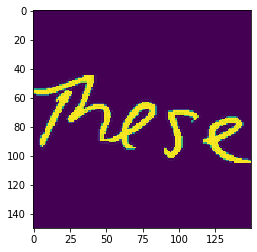

<matplotlib.image.AxesImage at 0x7f59103aefd0>

In [0]:
plt.imshow(df.X.iat[1000])

In [0]:
df.y.iat[11000]

Out[38]: 'Francis'